In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Data preparation

In [2]:
cities = pd.read_csv('data/city.csv')
cities.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000,2200,UTC+7,53.347997,83.779806,635585,1730


In [3]:
def str2int(population: str):
    if population.endswith(']'):
        return int(population[:-3])
    else:
        return int(population)

cities.loc[:, 'population'] = list(map(str2int, cities.population))
cities = cities[['address', 'geo_lat', 'geo_lon', 'population']]

cities30 = cities.sort_values(by='population', ascending=False).head(30)
cities30.reset_index(inplace=True, drop=True)
cities30.head()

,address,geo_lat,geo_lon,population
0,г Москва,55.754047,37.620405,11514330
1,г Санкт-Петербург,59.939131,30.315900,4848742
2,г Новосибирск,55.028191,82.921149,1498921
3,г Екатеринбург,56.838522,60.605491,1377738
4,г Нижний Новгород,56.324063,44.005391,1250615


In [4]:
import geopy.distance

def get_distance(coords1: tuple, coords2: tuple):
    return geopy.distance.geodesic(coords1, coords2).km

In [5]:
f_dist, s_dist = cities30[['geo_lat', 'geo_lon']].iloc[:2].values
print(f_dist, s_dist)
print(get_distance(f_dist, s_dist))

[55.7540471 37.620405 ] [59.9391313 30.3159004]
636.0231024849263


## Optimization

In [6]:
cities30.head()

,address,geo_lat,geo_lon,population
0,г Москва,55.754047,37.620405,11514330
1,г Санкт-Петербург,59.939131,30.315900,4848742
2,г Новосибирск,55.028191,82.921149,1498921
3,г Екатеринбург,56.838522,60.605491,1377738
4,г Нижний Новгород,56.324063,44.005391,1250615


In [7]:
def compute_path_distance(data: pd.DataFrame, path: np.ndarray) -> float:
    total_dist = 0
    for i in range(1, len(path)):
        prev_coords = data[['geo_lat', 'geo_lon']].iloc[path[i - 1]].values
        cur_coords = data[['geo_lat', 'geo_lon']].iloc[path[i]].values
        total_dist += np.abs(get_distance(prev_coords, cur_coords))
    return total_dist

def acceptance_prob(old_dist: float, new_dist: float, temp: float) -> float:
    return 1.0 if new_dist < old_dist else np.exp((old_dist - new_dist) / temp)

def optimize(data: pd.DataFrame, annealing_rate=0.95) -> (float, np.ndarray):
    t = 0
    temp = 10000
    annealing_rate = annealing_rate
    annealing_schedule = 7
    city_idx_range = list(range(30))

    cur_path = np.random.choice(data.index.values, size=data.index.size, 
                                 replace=False)
    best_path = cur_path.copy()
    best_dist = compute_path_distance(data, best_path)

    path_evolutions = []
    while (temp > 1):
        # select cities to swap
        from_id, to_id = np.random.choice(city_idx_range, size=2, replace=False)
        # make swap and create new path
        new_path = best_path.copy()
        new_path[from_id], new_path[to_id] = new_path[to_id], new_path[from_id]
        
        new_dist = compute_path_distance(data, new_path)
        cur_dist = compute_path_distance(data, cur_path)
        
        ap = acceptance_prob(cur_dist, new_dist, temp)
        if ap > np.random.rand():
            cur_path = new_path
            cur_dist = new_dist

        if cur_dist < best_dist:
            best_path = cur_path.copy()
            best_dist = cur_dist

        if t > 0 and t % annealing_schedule == 0:
            # temperature annealing and distance reporting
            print(f'Temperature = {temp} | Best distance = {best_dist}')
            temp *= annealing_rate
            path_evolutions.append(best_path)

        t += 1
    
    print(f'Final Temperature = {temp} | Final Best distance = {best_dist}')
    return best_dist, best_path, path_evolutions

### Slow cooling

In [8]:
%%time
best_dist, best_path, path_evolutions = optimize(cities30, 0.95)

Temperature = 10000 | Best distance = 52364.022441363755
Temperature = 9500.0 | Best distance = 51907.76186131735
Temperature = 9025.0 | Best distance = 49039.48506643357
Temperature = 8573.75 | Best distance = 42922.12103248526
Temperature = 8145.0625 | Best distance = 42538.81404835927
Temperature = 7737.809375 | Best distance = 40940.30856577412
Temperature = 7350.918906249999 | Best distance = 40499.69135977706
Temperature = 6983.372960937499 | Best distance = 40499.69135977706
Temperature = 6634.204312890623 | Best distance = 40457.20608522049
Temperature = 6302.494097246092 | Best distance = 38832.50906941596
Temperature = 5987.369392383787 | Best distance = 37617.01722025796
Temperature = 5688.000922764598 | Best distance = 37319.08885554996
Temperature = 5403.600876626368 | Best distance = 36552.80627934836
Temperature = 5133.420832795049 | Best distance = 36042.3188171772
Temperature = 4876.749791155296 | Best distance = 36042.3188171772
Temperature = 4632.912301597531 | Best 

Temperature = 20.163050597632513 | Best distance = 22778.089655529217
Temperature = 19.154898067750885 | Best distance = 22778.089655529217
Temperature = 18.19715316436334 | Best distance = 22778.089655529217
Temperature = 17.28729550614517 | Best distance = 22494.368154690517
Temperature = 16.422930730837912 | Best distance = 22494.368154690517
Temperature = 15.601784194296016 | Best distance = 22470.236881583132
Temperature = 14.821694984581214 | Best distance = 22470.236881583132
Temperature = 14.080610235352152 | Best distance = 22470.236881583132
Temperature = 13.376579723584543 | Best distance = 22470.236881583132
Temperature = 12.707750737405314 | Best distance = 22470.236881583132
Temperature = 12.072363200535047 | Best distance = 22470.236881583132
Temperature = 11.468745040508294 | Best distance = 22470.236881583132
Temperature = 10.895307788482878 | Best distance = 22470.236881583132
Temperature = 10.350542399058734 | Best distance = 22470.236881583132
Temperature = 9.833015

In [9]:
best_path_named = list(map(lambda x: cities30.iloc[x].address, best_path))
print('Best distance:', best_dist)
print('Best path (encoded)', best_path)
print('Best path (decoded)', best_path_named)

Best distance: 19370.559818876143
Best path (encoded) [ 1  0 22 19 24  7 18 29  2 28 23 21 26 13  8  3 12 10 27  6  5  4 20 17
 11 25 16  9 14 15]
Best path (decoded) ['г Санкт-Петербург', 'г Москва', 'г Ярославль', 'г Ижевск', 'Тюменская обл, г Тюмень', 'г Омск', 'г Барнаул', 'г Кемерово', 'г Новосибирск', 'Кемеровская область - Кузбасс, г Новокузнецк', 'г Иркутск', 'г Владивосток', 'г Хабаровск', 'г Красноярск', 'г Челябинск', 'г Екатеринбург', 'г Пермь', 'г Уфа', 'г Оренбург', 'г Самара', 'г Казань', 'г Нижний Новгород', 'г Ульяновск', 'Самарская обл, г Тольятти', 'г Волгоград', 'г Махачкала', 'г Краснодар', 'г Ростов-на-Дону', 'г Воронеж', 'г Саратов']


### Fast cooling

In [10]:
%%time
optimize(cities30, 0.1)

Temperature = 10000 | Best distance = 59033.41650535962
Temperature = 1000.0 | Best distance = 55955.793269943315
Temperature = 100.0 | Best distance = 55491.52317671826
Temperature = 10.0 | Best distance = 52965.211770643
Final Temperature = 1.0 | Final Best distance = 52965.211770643
CPU times: user 2.86 s, sys: 33.3 ms, total: 2.89 s
Wall time: 2.9 s


(52965.211770643,
 array([ 8,  3, 17, 15,  7,  6,  9, 22, 24,  1, 26, 10, 13, 11,  0, 29, 12,
        19,  5, 18, 21, 28,  2, 27, 20, 25, 16, 14,  4, 23]),
 [array([ 8,  3,  5, 15,  7,  6,  9, 22, 24,  1, 26, 10, 13, 27,  0, 29, 18,
          4, 17, 12, 21,  2, 23, 11, 19, 28, 16, 14, 20, 25]),
  array([ 8,  3,  5, 15,  7,  6,  9, 22, 24,  1, 26, 10, 13, 27,  0, 29, 12,
          4, 17, 18, 21,  2, 23, 11, 20, 25, 16, 14, 19, 28]),
  array([ 8,  3,  5, 15,  7,  6,  9, 22, 24,  1, 26, 10, 13, 27,  0, 29, 12,
         19, 17, 18, 21,  2, 23, 11, 20, 25, 16, 14,  4, 28]),
  array([ 8,  3, 17, 15,  7,  6,  9, 22, 24,  1, 26, 10, 13, 11,  0, 29, 12,
         19,  5, 18, 21, 28,  2, 27, 20, 25, 16, 14,  4, 23])])

### Middle cooling

In [11]:
%%time
optimize(cities30, 0.525)

Temperature = 10000 | Best distance = 56204.28709104547
Temperature = 5250.0 | Best distance = 51184.91822837005
Temperature = 2756.25 | Best distance = 47580.186170453664
Temperature = 1447.03125 | Best distance = 43818.41082831806
Temperature = 759.69140625 | Best distance = 40399.47903860776
Temperature = 398.83798828125003 | Best distance = 38862.31595724813
Temperature = 209.38994384765627 | Best distance = 38862.31595724813
Temperature = 109.92972052001954 | Best distance = 37449.99361117403
Temperature = 57.71310327301026 | Best distance = 31666.826853865976
Temperature = 30.29937921833039 | Best distance = 29498.347912353835
Temperature = 15.907174089623455 | Best distance = 29104.930689742956
Temperature = 8.351266397052314 | Best distance = 28684.949388113855
Temperature = 4.384414858452465 | Best distance = 28068.410629566315
Temperature = 2.3018178006875445 | Best distance = 28068.410629566315
Temperature = 1.2084543453609609 | Best distance = 28068.410629566315
Final Tempe

(28068.410629566315,
 array([12,  3,  0, 17, 20, 15, 24,  7,  8,  2, 10, 25, 11, 14,  1, 22, 16,
         9, 27, 19,  4,  5,  6, 29, 13, 21, 26, 23, 18, 28]),
 [array([23, 11, 22, 10, 20,  0,  6,  7, 18, 24, 28, 29,  3, 15,  1, 12, 16,
         21,  2, 17, 19, 14, 27, 25, 13,  5, 26,  8,  4,  9]),
  array([23, 11,  0, 10, 20,  8, 27,  7, 18, 24,  5, 29,  3, 15,  1, 22, 16,
         21,  2, 17, 19, 14,  6, 25, 13, 28, 26, 12,  4,  9]),
  array([23, 11, 25, 10, 20,  8, 27,  7, 18, 24,  5,  0,  3, 15,  1, 22, 16,
         21,  2, 17, 19, 14,  6, 29, 13, 28, 26, 12,  4,  9]),
  array([23, 11, 25, 10, 20,  8, 27,  7, 18, 24,  5,  0,  3, 19,  1, 22, 16,
          9,  2, 17, 15, 14,  6, 29, 13, 28, 26, 12,  4, 21]),
  array([23,  3, 25, 10, 20,  8, 27,  7, 18, 24,  5,  0, 11, 19,  1, 22, 16,
          9,  2, 17, 15, 14,  6, 29, 13, 21, 26, 12,  4, 28]),
  array([23,  3, 25, 10, 20,  4, 27,  7, 18, 24,  5,  0, 11, 19,  1, 22, 16,
          9,  2, 17, 15, 14,  6, 29, 13, 21, 26, 12,  8, 28]),
 

## Visualization

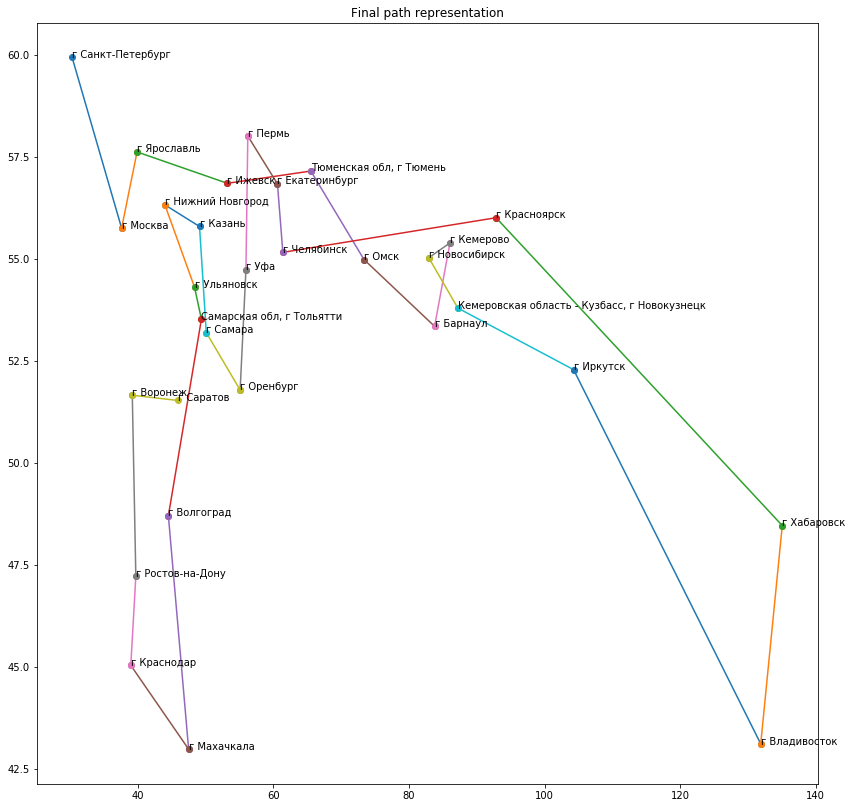

In [12]:
plt.rcParams["figure.figsize"] = [14, 14]
for i in range(1, len(best_path)):
    from_coords = cities30.iloc[best_path[i - 1]][['geo_lon', 'geo_lat']].values
    to_coords = cities30.iloc[best_path[i]][['geo_lon', 'geo_lat']].values
    plt.plot([from_coords[0], to_coords[0]], [from_coords[1], to_coords[1]], '-o')

for idx, name in zip(best_path, best_path_named):
    lat, lon = cities30[['geo_lon', 'geo_lat']].iloc[idx].values
    plt.annotate(name, (lat, lon))

plt.title('Final path representation')
plt.show()

In [15]:
plt.rcParams["figure.figsize"] = [12, 12]
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

ax.set_xlim((25, 150))
ax.set_ylim((42, 61))

for idx, name in zip(best_path, best_path_named):
    lat, lon = cities30[['geo_lon', 'geo_lat']].iloc[idx].values
    ax.annotate(name, (lat, lon))

lines = []
for index in range(len(best_path) - 1):
    lobj, = ax.plot([], [], '-o', lw=2)
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(idx):
    path = path_evolutions[idx]
    res = []
    for i in range(1, len(path)):
        from_coords = cities30.iloc[path[i - 1]][['geo_lon', 'geo_lat']].values
        to_coords = cities30.iloc[path[i]][['geo_lon', 'geo_lat']].values
        x = [from_coords[0], to_coords[0]]
        y = [from_coords[1], to_coords[1]]
        lines[i - 1].set_data(x, y)
    distance = compute_path_distance(cities30, path)
    ax.set_title(f'Best path with distance = {distance}, iter = {idx}')
    return lines
  

anim = animation.FuncAnimation(fig, animate, init_func=init, repeat=False,
                               frames=len(path_evolutions), interval=125, 
                               blit=True) 

rc('animation', html='jshtml')
anim

In [14]:
anim.save('images/algo_animation.gif', writer='imagemagick', fps=5) 

MovieWriter imagemagick unavailable. Trying to use pillow instead.
